In [1]:
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from numpy import linalg as LA
import math
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
## Vectorize 28*28 dimensions to flat 784
## Also convert F*N matrix to N*F
def vectorized(matrix):
    dim = matrix.shape
    return matrix.reshape(dim[0]*dim[1],dim[2]).T

In [3]:
## Dataset contains data in format {label:featureMatrix}. 
## Convert that to feature matrix X and label matrix y.
def matricized(dataset):
    X = np.concatenate(list(dataset.values()))
    y = np.concatenate([np.full(matrix.shape[0], label) for label,matrix in dataset.items()])
    return X,y

In [4]:
def plotXY(xy, labels=None, title="X,Y", xLabel="X", yLabel="Y", classLabel="Class"):
    x = xy[:, 0]
    y = xy[:, 1]
    if labels is None:
        labels = np.zeros(xy.shape[0])
    plotData = pd.DataFrame({xLabel: x, yLabel: y, classLabel: map(str, labels)})
    p = sns.jointplot(data=plotData, hue=classLabel, x=xLabel, y=yLabel)
    p.fig.suptitle(title)
    p.ax_joint.collections[0].set_alpha(0.8)
    p.fig.tight_layout()
    p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    plt.show()

In [5]:
def plotDist(grid, dists, context = "MLE plots",  xLabel="PC-0", yLabel="PC-1", classLabels=["0", "1"]):
    x, y = grid
    pos = np.dstack((x, y))
    fig = plt.figure(context)
    legends = []
    ax = fig.add_subplot(111)
    for classLabel,c,dist in zip(classLabels, ["Blues", "Reds"], dists):
        cs = ax.contour(x, y, dist.pdf(pos), cmap=c, alpha=0.7)
        cs.collections[-1].set_label(classLabel)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(context)
    plt.legend(title="Class",loc='upper left')
    plt.show

In [6]:
## Load data from mat files
def loadData():
    matFiles = [fileName for fileName in Path(".").iterdir() if (fileName.is_file() and fileName.suffix==".mat")]
    testData = {}
    trainData = {}
    for matFile in matFiles:
        data = scipy.io.loadmat(matFile)
        if matFile.stem.startswith("test"):
            testData[int(matFile.stem.split("_")[-1])] = vectorized(data[sorted(data.keys())[-1]])
        elif matFile.stem.startswith("train"):
            trainData[int(matFile.stem.split("_")[-1])] = vectorized(data[sorted(data.keys())[-1]])
    return testData, trainData

In [7]:
## Task 2 and 3
## PCA Helper
class PCA:
    def __init__(self, matrix):
        self.fit(matrix)
        
    def showData(self, matrix, context="Data Loss", indices = [0], d=2):
        samples = len(indices)
        
        fig=plt.figure(context, figsize=(20, 20*samples))
        reduced = self.inverse_transform(self.transform(matrix, d), d)
        for i,r in enumerate(indices):
            fig.add_subplot(1, samples, i+1).set_title(str(r), fontsize=10)
            plt.axis('off')
            plt.imshow(matrix[r].reshape((28,28)), cmap='gray')
            plt.tight_layout()
        plt.show()
        fig=plt.figure(context, figsize=(20, 20*samples))
        for i,r in enumerate(indices):
            fig.add_subplot(1, samples, i+1)
            plt.axis('off')
            plt.imshow(reduced[r].reshape((28,28)), cmap='gray')
            plt.tight_layout()
        plt.show()
        
        
    def showDataLoss(self, matrix, samples=10, d=2):
        n = matrix.shape[0]
        chosen = np.random.randint(n, size=samples)
        self.showData(matrix, context="Data Loss", indices=chosen, d=d)
        
    def inverse_transform(self, matrix, d = 2):
        return np.dot(matrix, self.v[:,:d].T)
    
    def fit(self, matrix):
        self.org = matrix
        self.C = np.cov(matrix.T)
        self.w, self.v = LA.eig(self.C)
        idx = self.w.argsort()[::-1]   
        self.w, self.v = self.w[idx], self.v[:,idx]
        
    def transform(self, matrix, d = 2):
        f = self.v[:,:d]
        return np.dot(matrix,f)
    
    def plotComponents(self, n):
        
        plt.figure("PCA")
        plt.bar(np.arange(n), self.w[0:n], align='center', alpha=0.5)
        plt.xticks(np.arange(n), np.arange(n))
        plt.ylabel('Eigen Value')
        plt.xlabel('Principal Components')
        plt.title('PCA')
        plt.show()
        
    def plotData(self, matrix, labels, context="Data", dim=[0,1]):
        if len(dim) != 2:
            print("Request more than 2 Dim")
            return
        f = self.v[:,dim]
        latentSpace = np.dot(matrix,f)
        plotXY(latentSpace, labels=labels, title='PCA - {}'.format(context), xLabel='PC-{}'.format(dim[0]), yLabel='PC-{}'.format(dim[1]), classLabel='Class')
        
    
    def showEigenDigits(self, components=50):
        fig=plt.figure("Eigen Digits", figsize=(20*math.ceil( components/10), 20*10))
        for i in range(components):
            eigenV = self.v[:,i]
            eigenDigit = self.w[i]*eigenV.reshape((28,28))
            fig.add_subplot(math.ceil( components/10), 10, i+1).set_title('PC-'+str(i), fontsize=10)
            plt.axis('off')
            plt.imshow(eigenDigit, cmap='gray')
            plt.tight_layout()
        plt.show()

In [8]:
class BayesianClassifier:
    def __init__(self, X, y, priors=None):
        self.priors = priors
        self.train(X, y)
        
    @staticmethod
    def MLE(xy):
        sampleMean = np.mean(xy, axis=0)
        mleMean = sampleMean
        moment = xy-mleMean
        mleCov = np.dot(moment.T, moment)/xy.shape[0]
        return multivariate_normal(mean=mleMean, cov = mleCov),[mleMean, mleCov]
    
    def train(self, X, y):
        self.X = X
        self.y = y
        self.classes, counts = np.unique(y, return_counts=True)
        if self.priors is None:
            self.priors = counts/y.shape[0]
            print("\tCalculated priors: "+self.priors)
        self._estimateDensities()
        
    def _estimateDensities(self):
        self.densities = []
        self.params = []
        for c in self.classes:
            classIndices = np.where(self.y == c)
            classData = self.X[classIndices[0],:]
            density, params = BayesianClassifier.MLE(classData)
            self.densities.append(density)
            self.params.append(params)
    
    def predict(self, X):
        prob = np.stack([density.pdf(X)*prior for density,prior in zip(self.densities, self.priors)],axis=0)
        prob /= prob.sum(axis=0)
        np.savetxt("density.csv", prob, delimiter=",")
        def lookup(i):
            return self.classes[i]
        return lookup(np.argmax(prob,axis=0))
    
    def _summary(self, X, y, title=""):
        y_pred = bc.predict(X)
        confusionMatrix = np.zeros((len(self.classes), len(self.classes)))
        for i,j in zip(y_pred, y):
            confusionMatrix[i][j] += 1
        df_cm = pd.DataFrame(confusionMatrix.astype(int), self.classes, self.classes)
        plt.figure(title+" Summary")
        sns.set(font_scale=1) # for label size
        ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", fmt="d", cbar=False) # font size
        ax.set_title("{} Accuracy: {:.3f}".format(title, np.trace(confusionMatrix)/np.sum(confusionMatrix)))
        plt.xlabel("Predicted Class")
        plt.ylabel("Actual Class")
        plt.show()
        return "{} Accuracy: {:.3f}".format(title, np.trace(confusionMatrix)/np.sum(confusionMatrix))
        
    def trainingSummary(self):
        return self._summary(self.X, self.y, title= "Training")
    
    def testingSummary(self, X, y):
        return self._summary(X, y, title= "Testing")
    
    def getErrors(self, X, y):
        y_pred = bc.predict(X)
        return [i for i,c,cp in zip(range(len(y)),y,y_pred) if c!=cp]
    
    def plotDensities(self):
        [xmin,ymin],[xmax,ymax] = np.min(self.X,axis=0), np.max(self.X,axis=0)
        grid = np.mgrid[xmin-2:xmax+2:.1, ymin-2:ymax+2:.1]
        plotDist(grid, self.densities, context="Max Likelihood Estimation Densities")

In [9]:
##  Task 1:
##  Normalize the ith feaature:
##            yi = (xi - mi)/si
##     mi = mean of feature i
##     si = SD of feature i
class Normalizer:
    def __init__(self, X):
        self.fit(X)
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        
    def fit_transfrm(self, X):
        self.fit(X)
        return self.transform(X)
    
    def transform(self, matrix):
        return (matrix-self.mean)/self.std

In [10]:
visualizeAll = True

In [11]:
print("0. Loading data")
testData,trainData = loadData()
train = [trainData[0].shape[0], trainData[1].shape[0]]
test = [testData[0].shape[0], testData[1].shape[0]]
print("\tLoaded {} training points and {} testing points".format(train, test))
XTrain,yTrain = matricized(trainData)
XTest,yTest = matricized(testData)

0. Loading data
	Loaded [5923, 6742] training points and [980, 1135] testing points


In [12]:
print("1. Conditioning Data")
normalizer = Normalizer(XTrain)
XTrain = normalizer.transform(XTrain)
XTest = normalizer.transform(XTest)

1. Conditioning Data


2. Performing PCA
	Plotting First 10 Principal Components


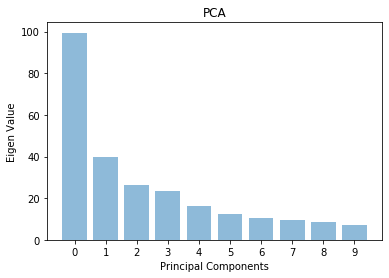

	Showing Top 10 Eigen Digits


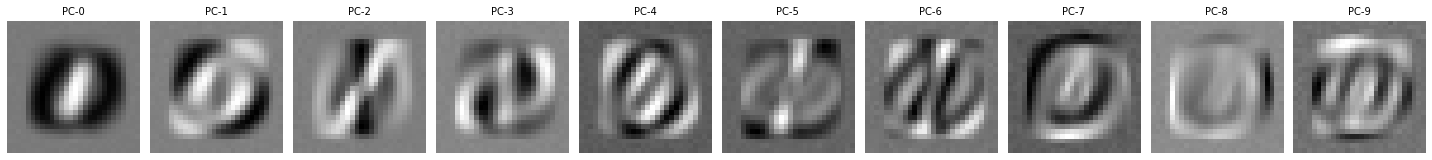

In [13]:
print("2. Performing PCA")
pca = PCA(XTrain)
print("\tPlotting First 10 Principal Components")
pca.plotComponents(10)
if visualizeAll:
    print("\tShowing Top 10 Eigen Digits")
    pca.showEigenDigits(10)

3. Reducing dimensions using PCA
	Plotting Test on Training points on reduced latent space


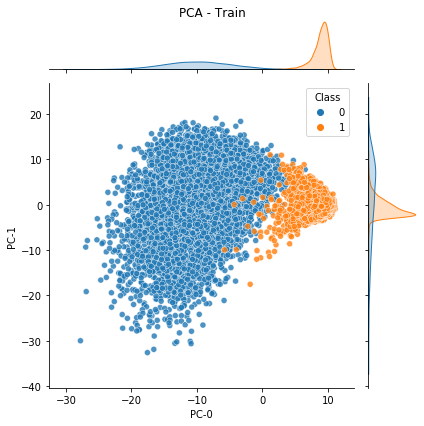

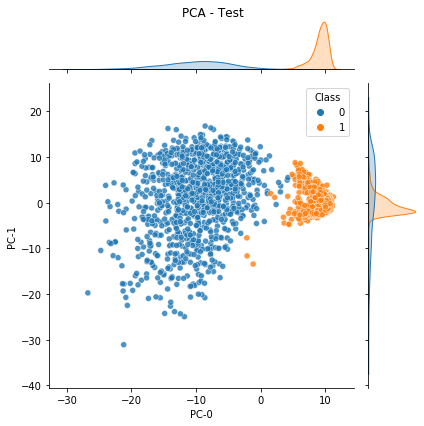

In [14]:
print("3. Reducing dimensions using PCA")
reducedTrain = pca.transform(XTrain,2)
reducedTest = pca.transform(XTest,2)    
print("\tPlotting Test on Training points on reduced latent space")
pca.plotData(XTrain, yTrain, dim=[0,1], context = "Train")
pca.plotData(XTest, yTest, dim=[0,1], context = "Test")

	Showing Randomly chosen Test data and the data loss


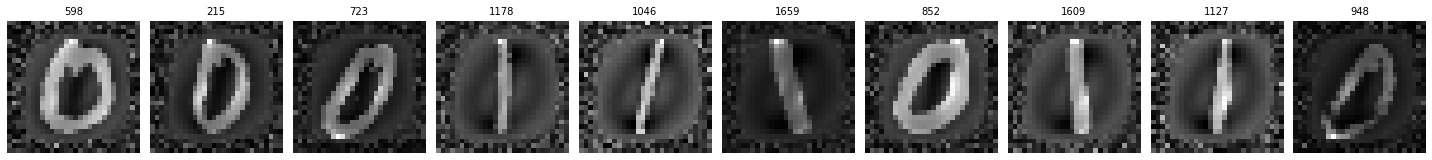

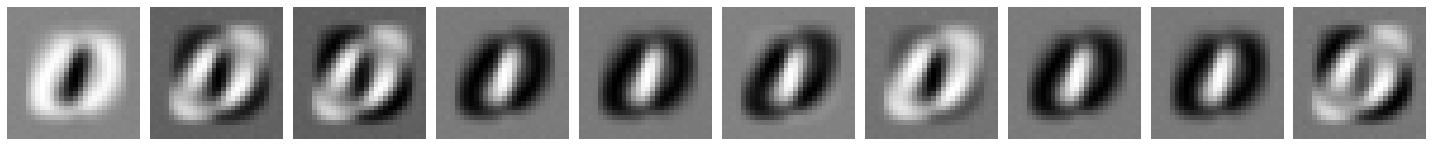

In [15]:
if visualizeAll:
    print("\tShowing Randomly chosen Test data and the data loss")
    pca.showDataLoss(XTest)

4. Performing MLE based Density estimation
	Plotting the estimated density for the classes
	Parameters of the estimated densities

	Class 0:
	 Mean: [-9.92384569  0.8514571 ]
	 Cov : [[25.32033003 15.89746017], [15.89746017 79.09976269]]

	Class 1:
	 Mean: [ 8.71832365 -0.74802439]
	 Cov : [[ 2.06646081 -0.0214822 ], [-0.0214822   4.08352963]]


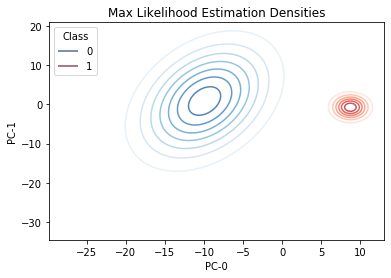

In [16]:
print("4. Performing MLE based Density estimation")
bc = BayesianClassifier(reducedTrain, yTrain, priors=[0.5,0.5])
print("\tPlotting the estimated density for the classes")
bc.plotDensities()
print("\tParameters of the estimated densities")
for c,p in zip(bc.classes, bc.params):
    print("\n\tClass {}:\n\t Mean: {}\n\t Cov : [{}, {}]".format(c, p[0], p[1][0], p[1][1]))


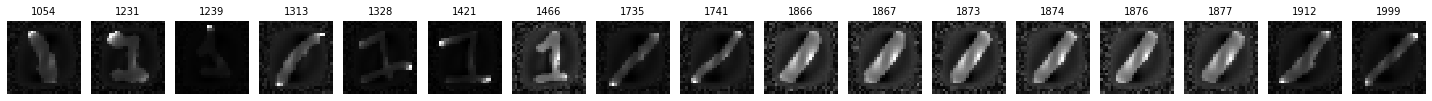

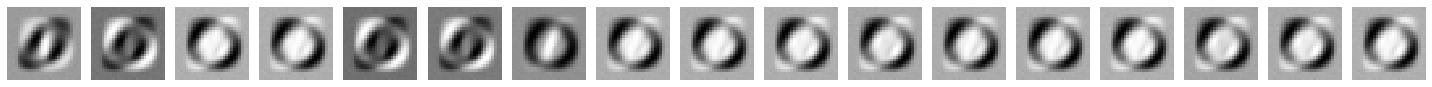

In [17]:
if visualizeAll:
    mismatch = bc.getErrors(reducedTest, yTest)
    pca.showData(XTest, context="Errors in classification", indices=mismatch, d=2)

5. Computing Accuracy of the model


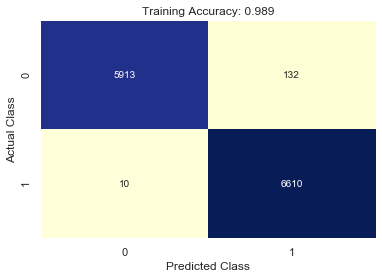

	Training Accuracy: 0.989


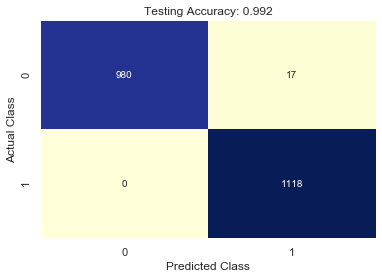

	Testing Accuracy: 0.992


In [18]:
print("5. Computing Accuracy of the model")
print("\t"+bc.trainingSummary())
print("\t"+bc.testingSummary(reducedTest, yTest))